In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.scores import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score, classification_report
import matplotlib.pyplot as plt
from lib.transformers_explainability import *

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.GoEmotionsCleaned
DATASET_NAME = 'GoEmotions'
MODEL_NAME = 'Roberta'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
FROZEN_LAYERS = 9
EPOCHS = 6
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()
# scores dictionary
SCORES = {'accuracy': accuracy,
          'jaccard_macro': jaccard,
          'f1_macro': f1,
          'jaccard_samples': jaccard_samples,
          'f1_micro':f1_micro,
          'membership':membership_score}

# Cross Validation

In [3]:
params_to_explore = {
    'learning_rate': [5e-05, 1e-05],
    'regularization': [0, 1e-05],
    'batch_size': [16, 32],
    'epochs': [EPOCHS],
    'frozen_layers': [FROZEN_LAYERS],
    'n_classes': [len(LABEL_COLS)],
}
RESULT_DIR = './results/' + DATASET_NAME + '/'
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.csv'
# create the grid search object
grid_search = HoldOutCrossValidation(Roberta, SCORES, train_df, val_df, param_dict=params_to_explore, res_file=RESULT_FILE)
# run the grid search
grid_search.run()

0it [00:00, ?it/s]

In [4]:
# load the results
results = grid_search.get_results()
# get the best parameters and scores according to F1 macro
best_info = grid_search.get_best_info('f1_macro')
print("BEST MODEL INFO")
print(best_info)
# print the results
print("RESULTS")
print(results)
print("BEST PARAMS")
BEST_PARAMS = grid_search.get_best_params('f1_macro')
BEST_PARAMS['batch_size'] = int(BEST_PARAMS['batch_size'])
BEST_PARAMS['epochs'] = int(BEST_PARAMS['epochs'])
BEST_PARAMS['frozen_layers'] = int(BEST_PARAMS['frozen_layers'])
BEST_PARAMS['n_classes'] = int(BEST_PARAMS['n_classes'])

BEST MODEL INFO
{'batch_size': 32.0, 'epochs': 6.0, 'frozen_layers': 9.0, 'learning_rate': 5e-05, 'n_classes': 28.0, 'regularization': 1e-05, 'train_accuracy': 0.5037318590186592, 'train_jaccard_macro': 0.4131293189336031, 'train_f1_macro': 0.5690887372934065, 'train_jaccard_samples': 0.6069016355678416, 'train_f1_micro': 0.6509211883037295, 'train_membership': 0.6852338170928357, 'val_accuracy': 0.4776999631404349, 'val_jaccard_macro': 0.373276503777086, 'val_f1_macro': 0.5254690426346077, 'val_jaccard_samples': 0.5719744440348937, 'val_f1_micro': 0.6097826086956522, 'val_membership': 0.6411721341688168}
RESULTS
   batch_size  epochs  frozen_layers  learning_rate  n_classes  \
0          16       6              9        0.00005         28   
1          32       6              9        0.00005         28   
2          16       6              9        0.00005         28   
3          32       6              9        0.00005         28   
4          16       6              9        0.000

In [5]:
# create the model with the best parameters
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


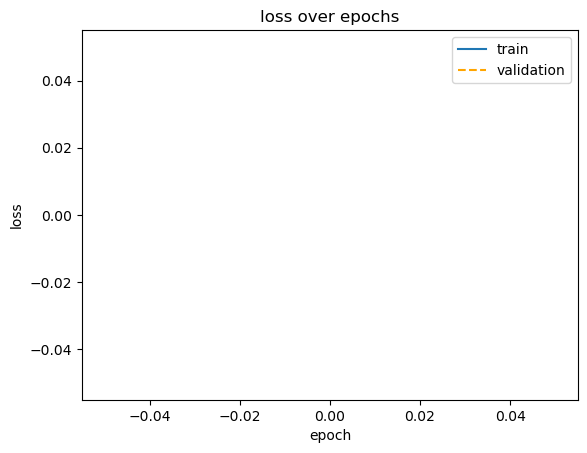

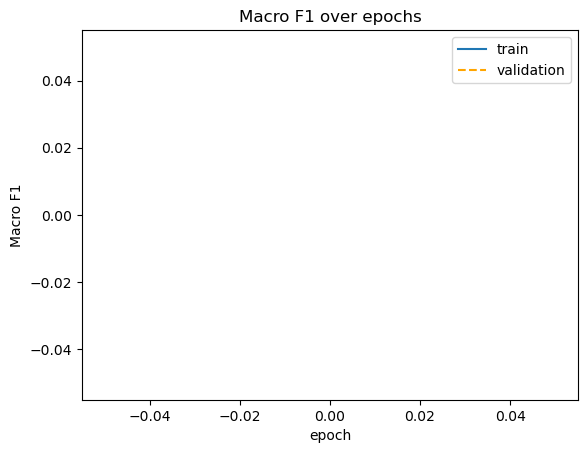

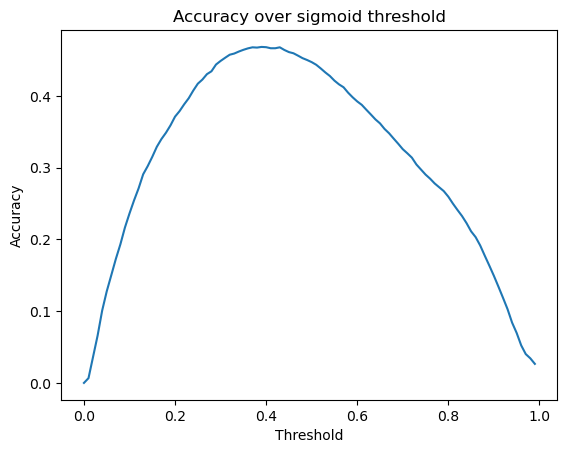

Best threshold: 0.39
Best Accuracy: 0.46811647622558056


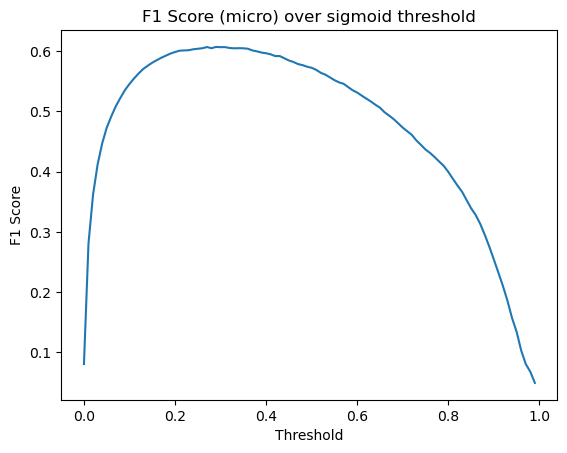

Best threshold: 0.29
Best F1 Score (micro): 0.6070780399274047


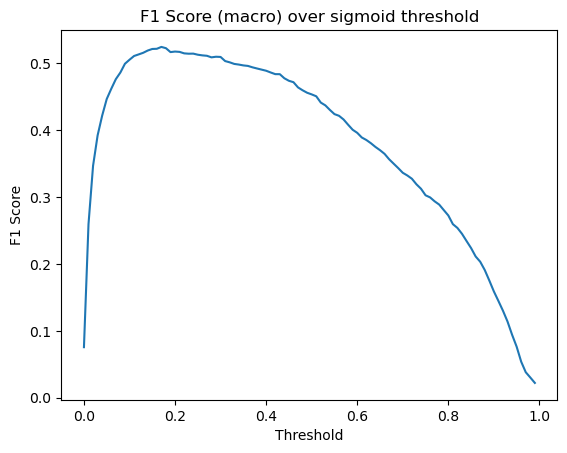

Best threshold: 0.17
Best F1 Score (macro): 0.5239744984393341


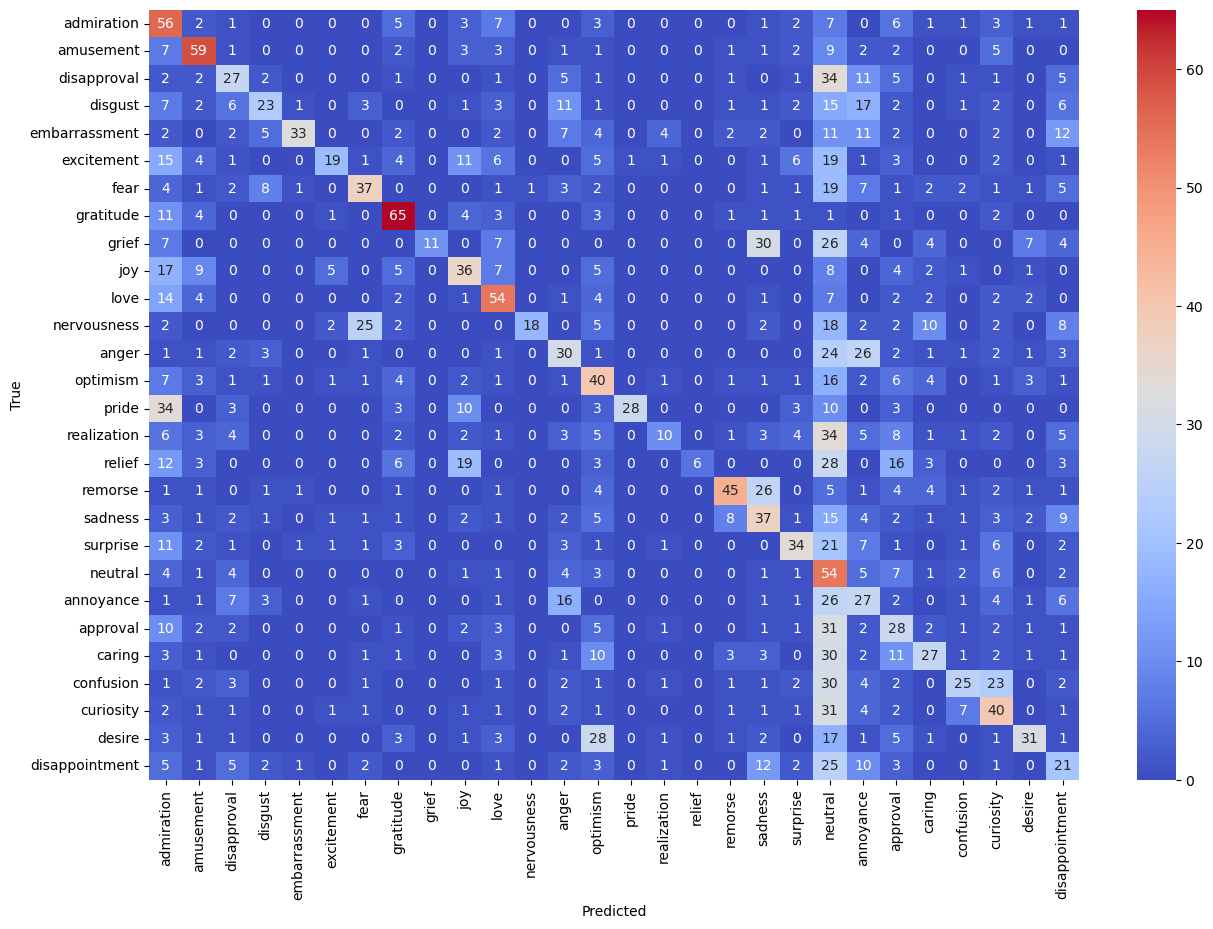

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

    admiration       0.53      0.88      0.66       488
     amusement       0.71      0.89      0.79       303
   disapproval       0.41      0.52      0.46       292
       disgust       0.41      0.47      0.44        97
 embarrassment       0.68      0.54      0.60        35
    excitement       0.49      0.33      0.40        96
          fear       0.62      0.68      0.65        90
     gratitude       0.88      0.90      0.89       358
         grief       0.75      0.23      0.35        13
           joy       0.55      0.63      0.59       172
          love       0.66      0.90      0.77       252
   nervousness       0.58      0.33      0.42        21
         anger       0.36      0.69      0.47       195
      optimism       0.39      0.72      0.50       209
         pride       0.80      0.53      0.64        15
   realization       0.48      0.18      0.26       127
        relief       0.33      0.11      0.17  

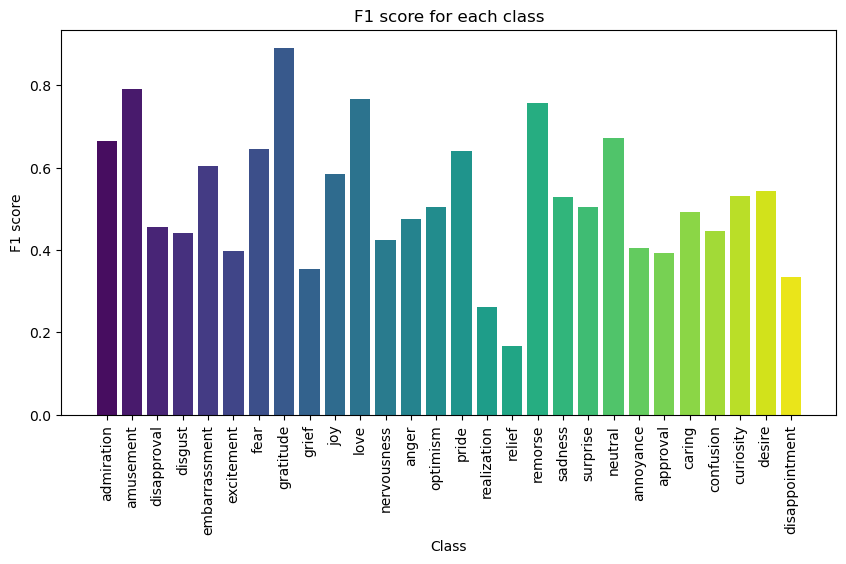

In [6]:
model_analysis(model, val_df, LABEL_COLS)#TODO refit for internal scores in plot

## Feature importance

In [7]:
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + MODEL_NAME + '_features.csv'#TODO tenere?
TOP_N = 30
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Attempt on grouped emotions

### Mapping predictions to Ekman

In [8]:
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + 'Grouped' + '_' + MODEL_NAME + '.pth'

In [9]:
# get model predictions on validation set#TODO include in bert?
out = model.predict(val_df)
# get best threshold
thresh, _ = tune_sigmoid_threshold(val_df[LABEL_COLS].values, out, f1_score, metric_params={'average':'macro', 'zero_division':0})
best_out = (out > thresh).astype(int)
# remove neutral label
neutral_idx = LABEL_COLS.index('neutral')
LABEL_COLS.pop(neutral_idx)
best_out = np.delete(best_out, neutral_idx, axis=1)

In [10]:
# map dataset emotions to Ekman taxonomy
train_df = goemotions_apply_emotion_mapping(train_df)
val_df = goemotions_apply_emotion_mapping(val_df)
test_df = goemotions_apply_emotion_mapping(test_df)
# names starting with 'ekman_' are the mapped emotions
EKMAN_LABELS = val_df.columns[val_df.columns.str.startswith('ekman_')].tolist()

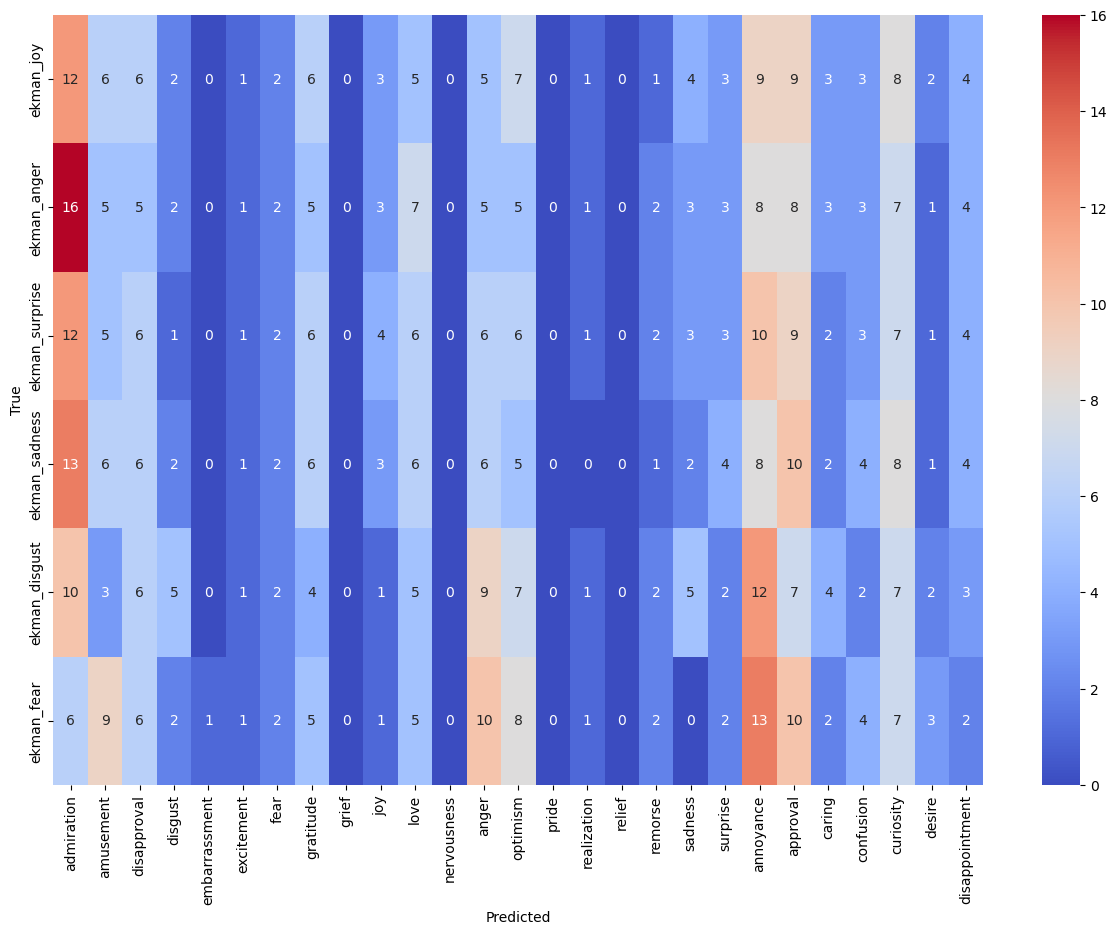

In [11]:
# visualize confusion matrix to understand induced mapping # TODO add and analyze in bert
plot_multilabel_confusion_heatmap(val_df[EKMAN_LABELS].values, best_out, EKMAN_LABELS, LABEL_COLS, normalize=True)#TODO transpose?

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6 [00:00<?, ?it/s]

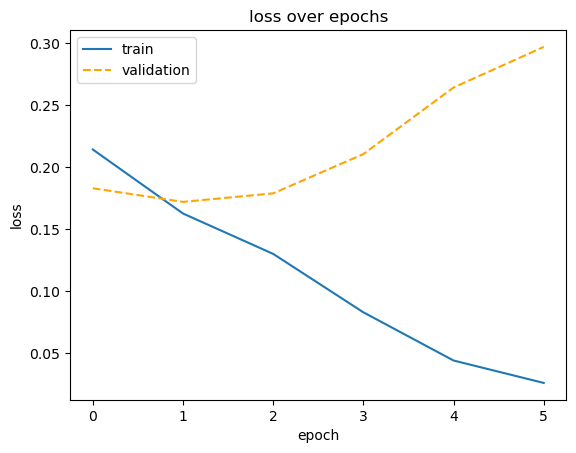

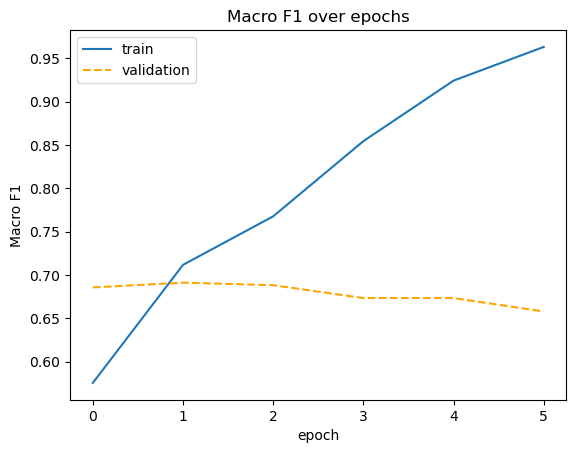

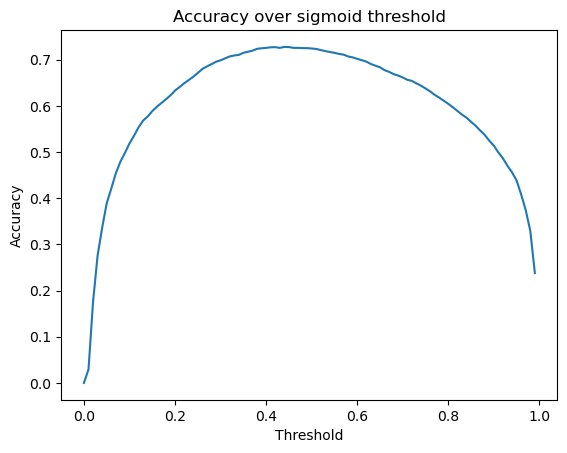

Best threshold: 0.44
Best Accuracy: 0.7276995305164319


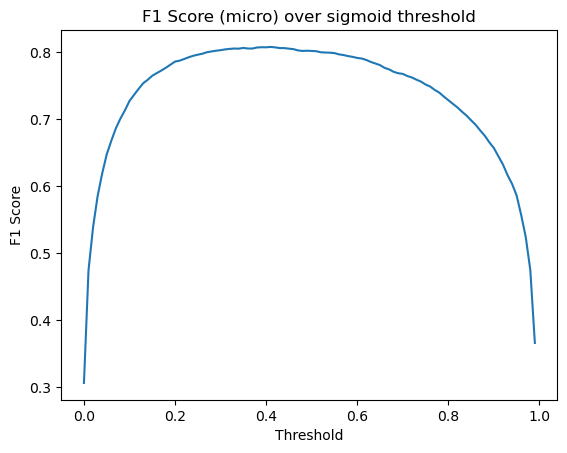

Best threshold: 0.41000000000000003
Best F1 Score (micro): 0.8079034028540066


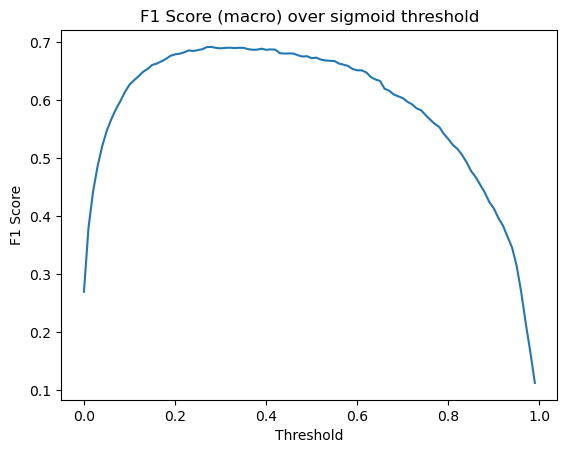

Best threshold: 0.28
Best F1 Score (macro): 0.6911906400880982


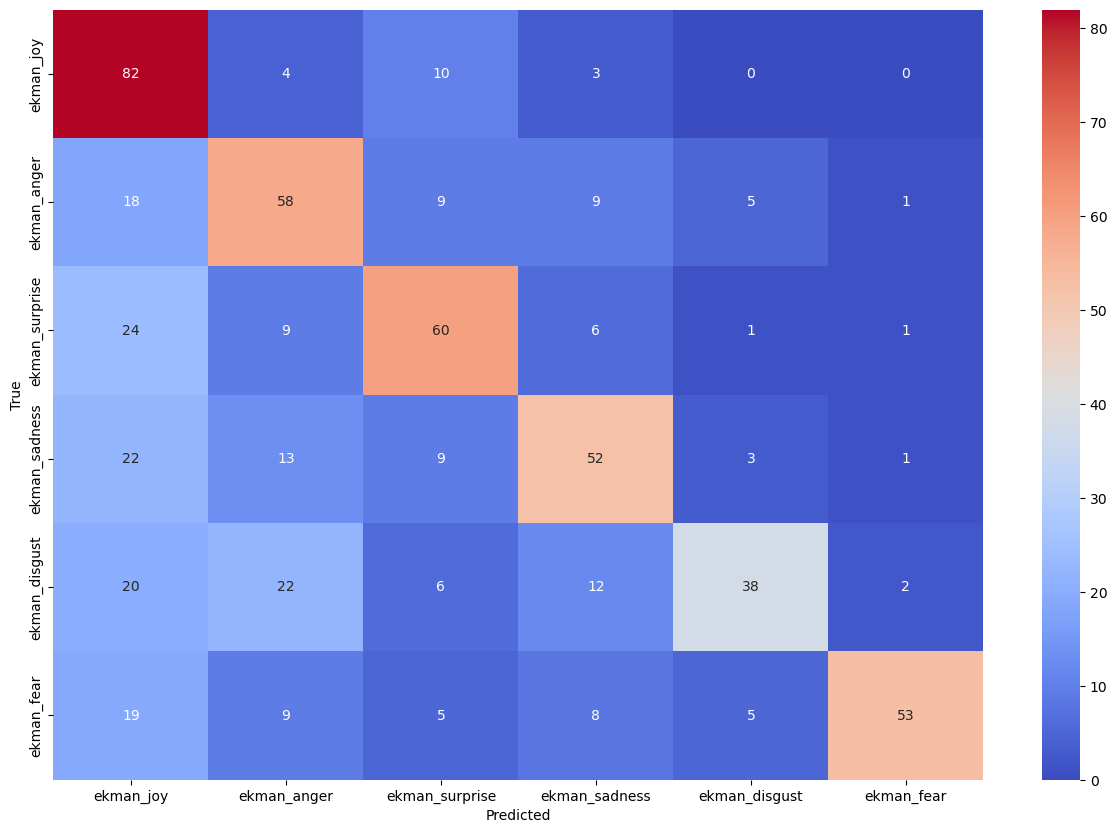

                precision    recall  f1-score   support

     ekman_joy       0.86      0.94      0.90      2219
   ekman_anger       0.71      0.75      0.73       717
ekman_surprise       0.62      0.78      0.69       624
 ekman_sadness       0.63      0.71      0.67       390
 ekman_disgust       0.45      0.49      0.47        97
    ekman_fear       0.72      0.66      0.69       105

     micro avg       0.76      0.85      0.80      4152
     macro avg       0.66      0.72      0.69      4152
  weighted avg       0.76      0.85      0.80      4152
   samples avg       0.81      0.87      0.82      4152

Jaccard Samples Score: 0.7889714832203095
Jaccard Macro Score: 0.5423658965001952
Membership Score: 0.8364632237871674


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


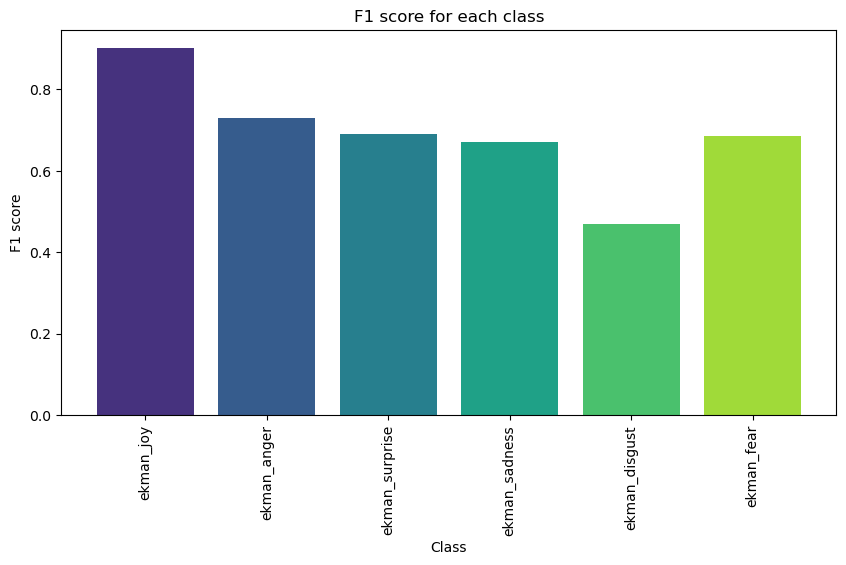

In [16]:
BEST_PARAMS['n_classes'] = len(EKMAN_LABELS)
# model analysis with Ekman mapped emotions
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)
model_analysis(model, val_df, EKMAN_LABELS)

## Feature importance on grouped dataset

In [17]:
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + 'Grouped' + '_' + MODEL_NAME + '_features.csv'#TODO tenere?
TOP_N = 30

## Mapping with twitter emotions (Parrott taxonomy)

In [18]:
DATASET = DatasetEnum.TwitterDataCleaned
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
train_df, val_df, test_df = load_dataset(DATASET)
TWITTER_LABEL = train_df.columns[1:].tolist()

In [19]:
BEST_PARAMS['n_classes'] = len(TWITTER_LABEL)
# create the model with the best parameters
model = Roberta(SCORES, BEST_PARAMS, CHECKPOINT_MODEL_FILE)
# fit the model if checkpoint does not exist
if not os.path.exists(CHECKPOINT_MODEL_FILE):
    model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=False, checkpoint_path=CHECKPOINT_MODEL_FILE, checkpoint_score='f1_macro', checkpoint_score_maximize=True)

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


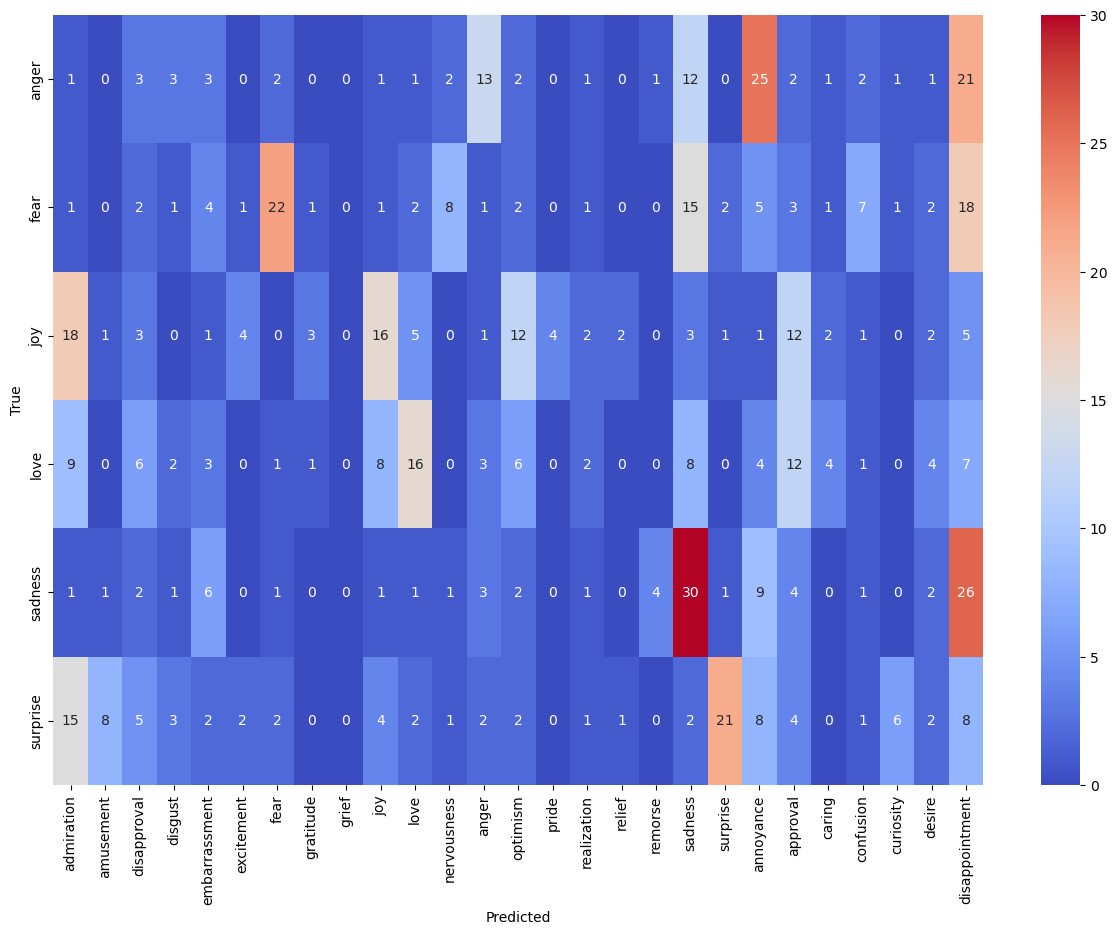

In [20]:
# get model predictions on validation set of Twitter dataset #TODO
out = model.predict(val_df)
best_out = (out > thresh).astype(int)
# remove neutral label
best_out = np.delete(best_out, neutral_idx, axis=1)
# visualize confusion matrix to understand induced mapping #TODO
plot_multilabel_confusion_heatmap(val_df[TWITTER_LABEL].values, best_out, TWITTER_LABEL, LABEL_COLS, normalize=True)